In [1]:
import sys
sys.path.append('..')

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from src.utils import publish_model_scores
from src.datasampling import dataSampling
from src.bayesianopt import bayesianOpt

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import (StandardScaler, RobustScaler)
from sklearn.ensemble import (IsolationForest, RandomForestClassifier)
from sklearn.feature_selection import (mutual_info_classif, f_classif, RFE)

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

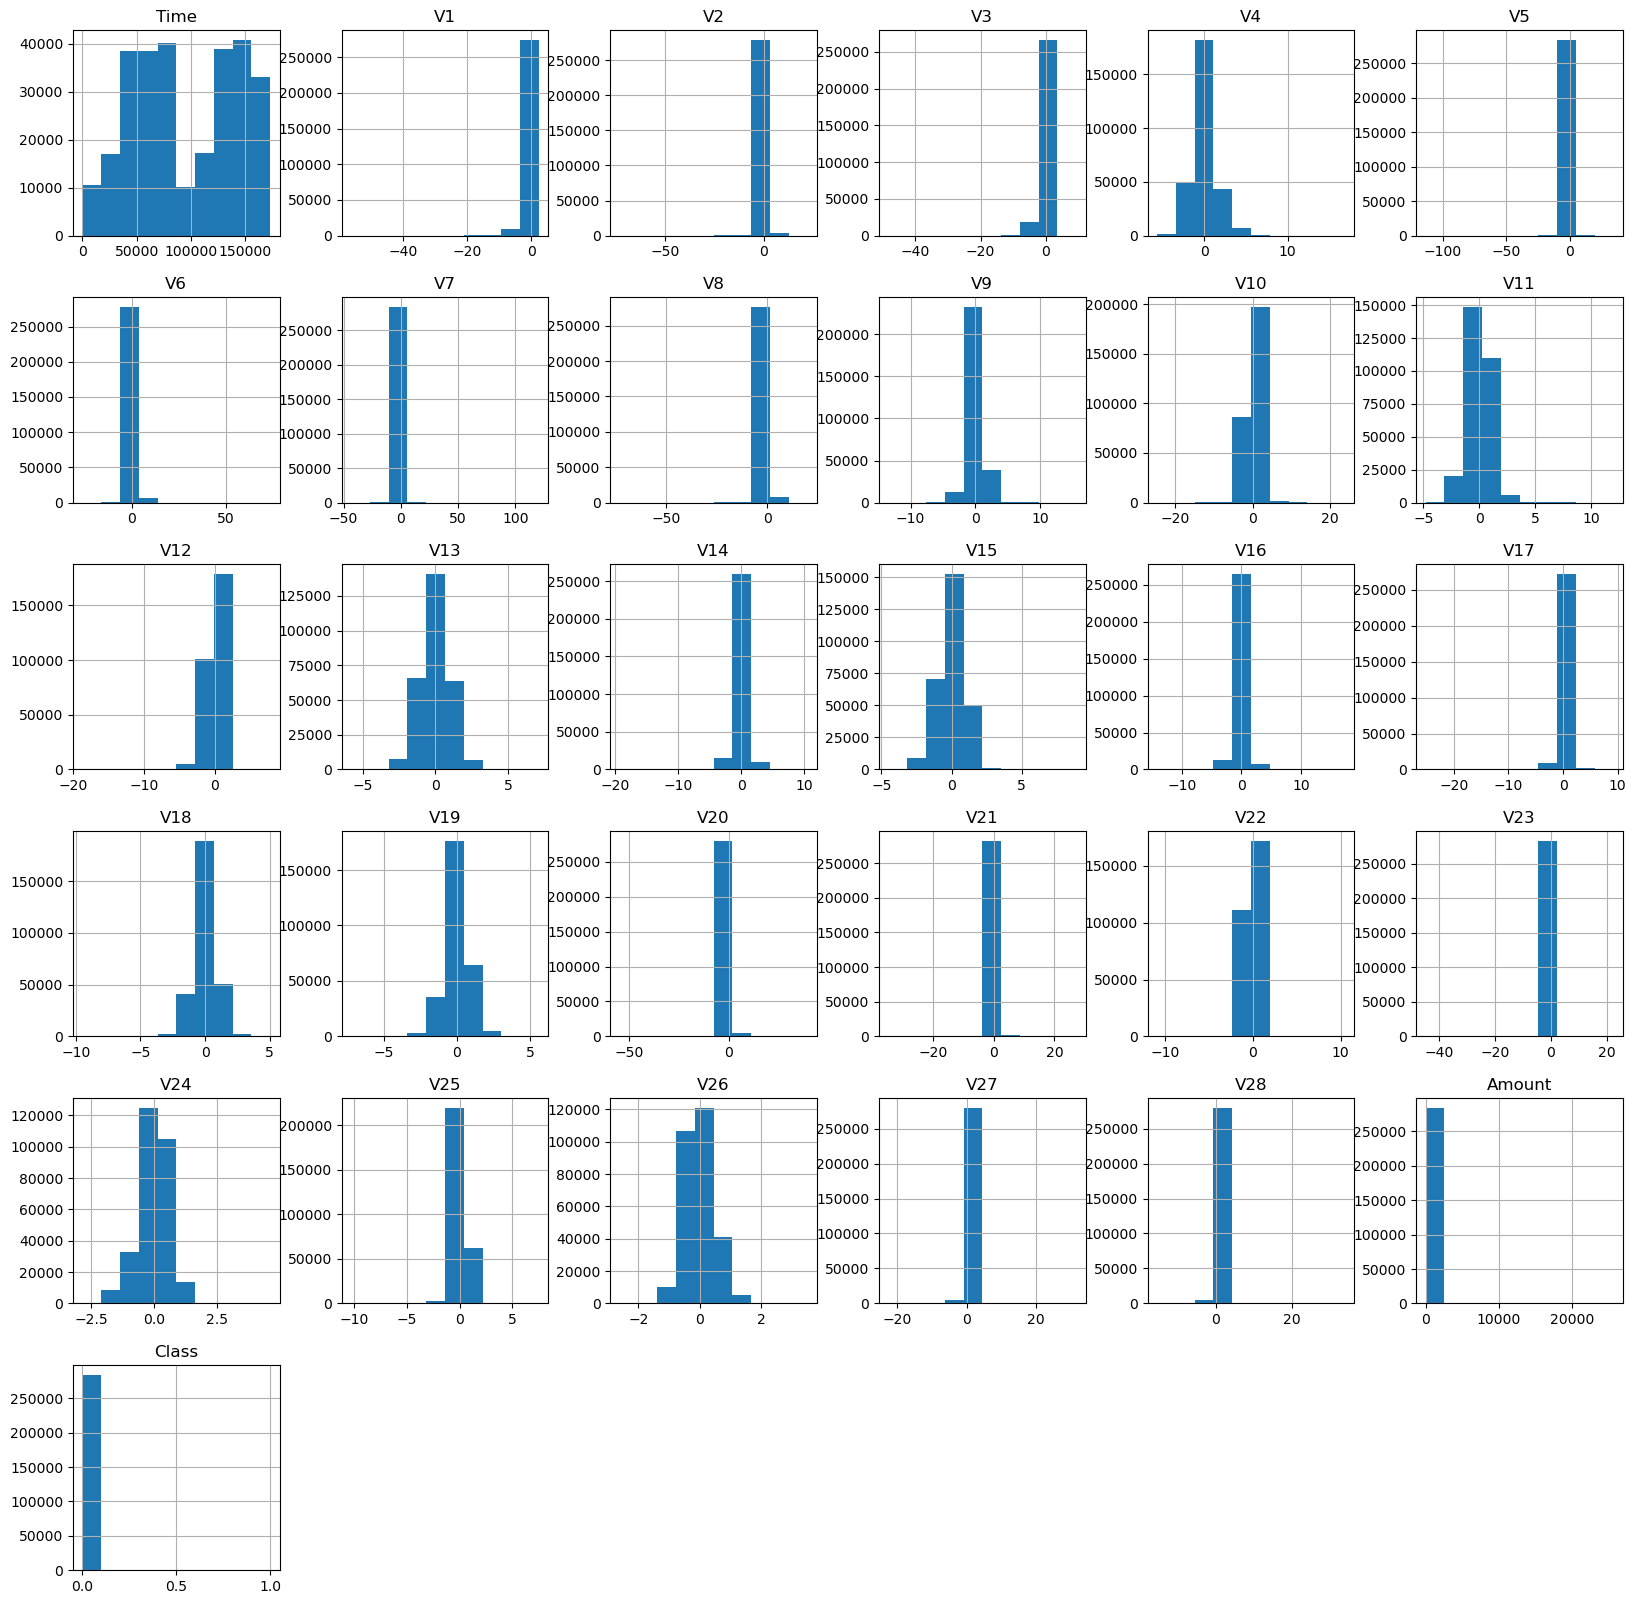

In [3]:
df = pd.read_csv("../creditcard.csv")
print(df.head(5))

# Plot the histogrm
df.hist(figsize = (20, 20))
plt.show()

# Comment : features are scaled so need not to do any standard transformation for preprocessing

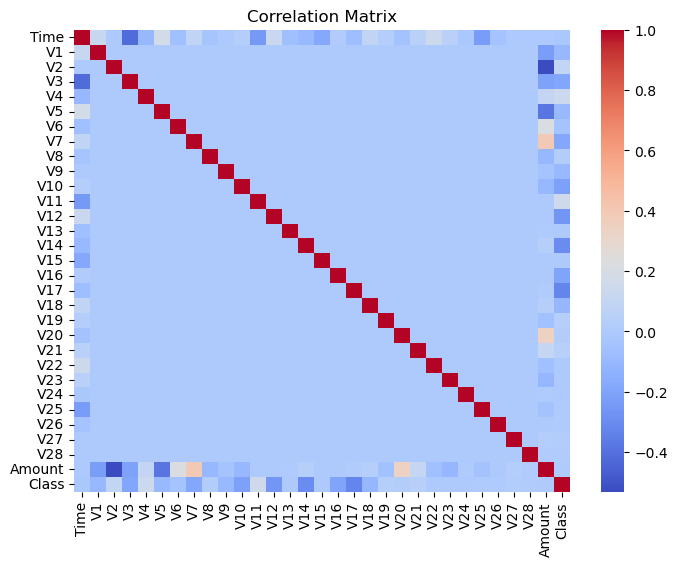

In [4]:
# Print the correlation of data
correlation_matrix = df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

#Comment : There is no significant correlation amoung the data so no need for reducing highly correlated data

In [5]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## FEATURE ENGINEERING

In [6]:
# time based features

def time_to_hour(time_in_seconds):
    return (time_in_seconds // (60 * 60)) % 24

# Adding new time-based features
df['HourOfDay'] = df['Time'].apply(time_to_hour)
df['Weekend'] = (df['HourOfDay'] >= 0) & (df['HourOfDay'] < 6)
df['Weekend'] = df['Weekend'].apply(lambda x: 1 if x else 0)

df.sort_values('Time', inplace=True)
df['Time_since_last_trans'] = df['Time'].diff().fillna(0)  # Fill NA for the first transaction

In [7]:
# amount based features

df['Log_Amount'] = np.log(df['Amount'] + 1e-9)  # Adding a small constant to avoid log(0)

# Amount bins
# Define bins for transaction amount
bins = [0, 25, 50, 75, 100, 125, 150, np.inf]
labels = [1, 2, 3, 4, 5, 6, 7]  # These are arbitrary labels for the bins
df['Amount_bin'] = pd.cut(df['Amount'], bins=bins, labels=labels)

In [8]:
# standardization of OG time and amount
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

In [9]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V27,V28,Class,HourOfDay,Weekend,Time_since_last_trans,Log_Amount,Amount_bin,scaled_amount,scaled_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.133558,-0.021053,0,0.0,1,0.0,5.008099,6,1.783274,-0.994983
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.008983,0.014724,0,0.0,1,0.0,0.989541,1,-0.269825,-0.994983
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,-0.055353,-0.059752,0,0.0,1,1.0,5.936639,7,4.983721,-0.994972
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.062723,0.061458,0,0.0,1,0.0,4.816241,5,1.418291,-0.994972
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.219422,0.215153,0,0.0,1,1.0,4.248352,3,0.670579,-0.994960


## FEATURE SELECTION

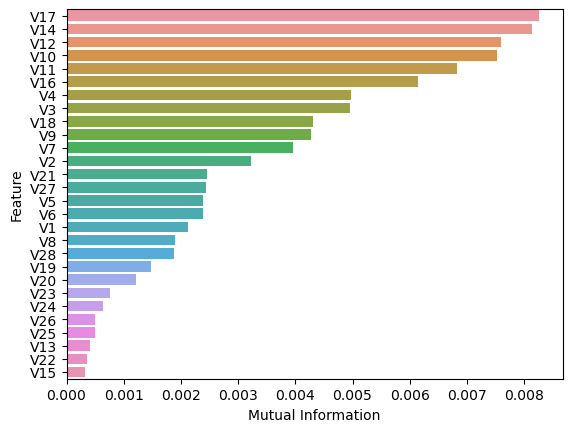

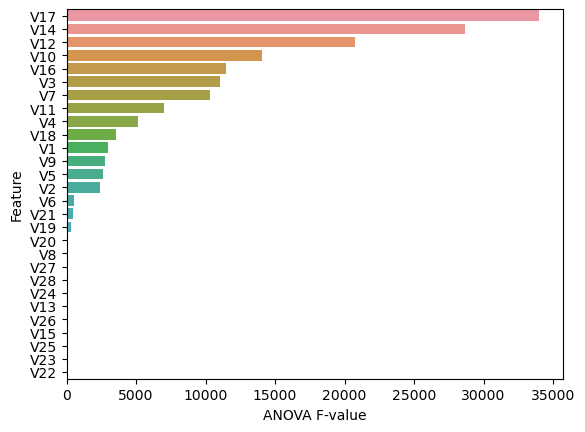

In [10]:
# filter methods

# checking correl b/w PCA features
X = df.filter(regex='^V\d+')
y = df['Class']

mi = mutual_info_classif(X, y)
f_scores, p_values = f_classif(X, y)

feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'Mutual Information': mi,
    'ANOVA F-value': f_scores,
    'p-value': p_values
})

sns.barplot(x='Mutual Information', y='Feature', data=feature_scores.sort_values(by='Mutual Information', ascending=False))
plt.show()

sns.barplot(x='ANOVA F-value', y='Feature', data=feature_scores.sort_values(by='ANOVA F-value', ascending=False))
plt.show()

Based on the above analysis, we can elect to drop columns V23, 22, 25, 15, 26, 13, 24, 28, 27, 8, 20, 19, 21, 6

In [11]:
columns_to_drop = ['V23', 'V22', 'V25', 'V15', 'V26', 'V13', 'V24', 'V28', 'V27', 'V8', 'V20', 'V19', 'V21', 'V6']
df = df.drop(columns=columns_to_drop)
df.head()

,V1,V2,V3,V4,V5,V7,V9,V10,V11,V12,...,V17,V18,Class,HourOfDay,Weekend,Time_since_last_trans,Log_Amount,Amount_bin,scaled_amount,scaled_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.239599,0.363787,0.090794,-0.551600,-0.617801,...,0.207971,0.025791,0,0.0,1,0.0,5.008099,6,1.783274,-0.994983
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.078803,-0.255425,-0.166974,1.612727,1.065235,...,-0.114805,-0.183361,0,0.0,1,0.0,0.989541,1,-0.269825,-0.994983
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,0.791461,-1.514654,0.207643,0.624501,0.066084,...,1.109969,-0.121359,0,0.0,1,1.0,5.936639,7,4.983721,-0.994972
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,0.237609,-1.387024,-0.054952,-0.226487,0.178228,...,-0.684093,1.965775,0,0.0,1,0.0,4.816241,5,1.418291,-0.994972
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.592941,0.817739,0.753074,-0.822843,0.538196,...,-0.237033,-0.038195,0,0.0,1,1.0,4.248352,3,0.670579,-0.994960


In [12]:
""" # Recursive Feature Elimination

X = df.filter(regex='^V\d+')
y = df['Class']

model = RandomForestClassifier()
#  check with logregclassifier
rfe = RFE(model, n_features_to_select=10)
rfe = rfe.fit(X, y)

print('Selected features: %s' % list(X.columns[rfe.support_])) """

" # Recursive Feature Elimination\n\nX = df.filter(regex='^V\\d+')\ny = df['Class']\n\nmodel = RandomForestClassifier()\n#  check with logregclassifier\nrfe = RFE(model, n_features_to_select=10)\nrfe = rfe.fit(X, y)\n\nprint('Selected features: %s' % list(X.columns[rfe.support_])) "

In [13]:
# note: perform (preprocessing/feature engineering/feature selection) up to this point to get 'df'

# 1. Evaluate Random Forest Classifier (without sampling techniques)

# 1.1 Get the data

In [14]:
# Make a data source object using dataSampling class
ds = dataSampling(df,"Class",0.30,42,True,True)

In [15]:
# Make in-smaple and out sample dataset without sampling
X_train,X_test,y_train,y_test = ds.get_data_without_sample()
ds.print_class_percentage(X_train,X_test,y_train,y_test)

=====Train class count=====
Class
0    199020
1       344
Name: count, dtype: int64
Class
0    0.998275
1    0.001725
Name: count, dtype: float64

=====Test class count=====
Class
0    85295
1      148
Name: count, dtype: int64
Class
0    0.998268
1    0.001732
Name: count, dtype: float64


# 1.2 Fit the Descion Tree Classifier and optimize Hyperparameters using Bayesian Optimization

In [20]:
# Parameter specifications
param_grid = {'criterion':['gini'],
              'max_depth': np.arange(1,10),
              "max_features": ['sqrt'],
              "min_samples_split": range(2,21),
              "class_weight": [{0:1, 1:1}, {0:1, 1:5}, {0:1, 1:50},'balanced'],
              "cv":[2],
              "scoring":["f1_macro"],
              "n_jobs":[-1]}

# Config dict for Bayesian Optimizer
conf_dict={"num_iteration":100}

# Fit and optimize the Bayesian model
rf_opt = bayesianOpt(RandomForestClassifier(random_state = 0))
best_model = rf_opt.optimize_fit(X_train,y_train,param_grid,conf_dict)

  0%|          | 0/100 [00:00<?, ?it/s]

# 1.3 See the performance on out-of-sample data

In [21]:
rf_opt.optimize_results["best_params"]

{'class_weight': {0: 1, 1: 5},
 'criterion': 'gini',
 'cv': 2,
 'max_depth': 9,
 'max_features': 'sqrt',
 'min_samples_split': 2,
 'n_jobs': -1,
 'scoring': 'f1_macro'}

In [22]:
print("------Training model Results------")
publish_model_scores(X_train,y_train,best_model)
print("\n------Testing model Result----------")
publish_model_scores(X_test,y_test,best_model)

------Training model Results------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199020
           1       0.97      0.84      0.90       344

    accuracy                           1.00    199364
   macro avg       0.98      0.92      0.95    199364
weighted avg       1.00      1.00      1.00    199364

ROC_AUC Score 0.9998470558060076

------Testing model Result----------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.96      0.78      0.86       148

    accuracy                           1.00     85443
   macro avg       0.98      0.89      0.93     85443
weighted avg       1.00      1.00      1.00     85443

ROC_AUC Score 0.9704003434820012


# 2. Evaluate using under sampling method

# 2.1 Get the data

In [10]:
X_nm_train,X_test,y_nm_train,y_test= ds.get_data_near_miss()
ds.print_class_percentage(X_nm_train,X_test,y_nm_train,y_test)

=====Train class count=====
Class
0    3440
1     344
Name: count, dtype: int64
Class
0    0.909091
1    0.090909
Name: count, dtype: float64


=====Test class count=====
Class
0    85295
1      148
Name: count, dtype: int64
Class
0    0.998268
1    0.001732
Name: count, dtype: float64


# 2.2 Fit the Descion Tree Classifier and optimize Hyperparameters using Bayesian Optimization

In [11]:
# Parameter specification
param_grid = {'criterion':['gini','entropy'],
              'max_depth': np.arange(1,15),
              "max_features": ['sqrt', 'log2'],
              "min_samples_split": range(2,21),
              "class_weight": [{0:1, 1:1}, {0:1, 1:5}, {0:1, 1:50},'balanced'],
              "cv":[2],
              "scoring":["f1_macro"],
              "n_jobs":[-1]}

# Config dict for Bayesian Optimizer
conf_dict={"num_iteration":100}

# Fit and Optimize the Baysian model
dt_nm_opt = bayesianOpt(DecisionTreeClassifier(random_state = 0))
best_nm_model = dt_nm_opt.optimize_fit(X_nm_train,y_nm_train,param_grid,conf_dict)

  0%|          | 0/100 [00:00<?, ?it/s]

# 2.3 See the performance on out-of-sample data

In [14]:
print("------Training model Results------")
publish_model_scores(X_nm_train,y_nm_train,best_nm_model)
print("------Testing model Result----------")
publish_model_scores(X_test,y_test,best_nm_model)

------Training model Results------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3440
           1       0.97      0.89      0.93       344

    accuracy                           0.99      3784
   macro avg       0.98      0.94      0.96      3784
weighted avg       0.99      0.99      0.99      3784

ROC_AUC Score 0.9895433342347215
------Testing model Result----------
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     85295
           1       0.02      0.84      0.03       148

    accuracy                           0.91     85443
   macro avg       0.51      0.87      0.49     85443
weighted avg       1.00      0.91      0.95     85443

ROC_AUC Score 0.8986454007791718


# 3. Evaluate using under sampling method SMOTE
# 3.1 Get the data sets using near miss sampling technique

In [15]:
X_sm_train,X_test,y_sm_train,y_test= ds.get_data_smote()
ds.print_class_percentage(X_sm_train,X_test,y_sm_train,y_test)

=====Train class count=====
Class
0    199020
1    199020
Name: count, dtype: int64
Class
0    0.5
1    0.5
Name: count, dtype: float64


=====Test class count=====
Class
0    85295
1      148
Name: count, dtype: int64
Class
0    0.998268
1    0.001732
Name: count, dtype: float64


# 3.2 Fit the data and tune the hyperparameters using Bayesian Optimization

In [16]:
# Parameter specification
param_grid = {'criterion':['gini','entropy'],
              'max_depth': np.arange(1,15),
              "max_features": ['sqrt', 'log2'],
              "min_samples_split": range(2,21),
              "class_weight": [{0:1, 1:1}, {0:1, 1:5}, {0:1, 1:50},'balanced'],
              "cv":[2],
              "scoring":["f1_macro"],
              "n_jobs":[-1]}

# Config dict for Bayesian Optimizer
conf_dict={"num_iteration":100}

# Fit and Optimize the Baysian model
dt_sm_opt = bayesianOpt(DecisionTreeClassifier(random_state = 0))
best_sm_model = dt_sm_opt.optimize_fit(X_sm_train,y_sm_train,param_grid,conf_dict)

  0%|          | 0/100 [00:00<?, ?it/s]

# 3.3 Evaluate the Performance

In [19]:
print("=====Training model Results=====")
publish_model_scores(X_sm_train,y_sm_train,best_sm_model)
print("\n=====Testing model Result=====")
publish_model_scores(X_test,y_test,best_sm_model)

=====Training model Results=====
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199020
           1       1.00      1.00      1.00    199020

    accuracy                           1.00    398040
   macro avg       1.00      1.00      1.00    398040
weighted avg       1.00      1.00      1.00    398040

ROC_AUC Score 0.9999074713533759

=====Testing model Result=====
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     85295
           1       0.18      0.77      0.30       148

    accuracy                           0.99     85443
   macro avg       0.59      0.88      0.65     85443
weighted avg       1.00      0.99      1.00     85443

ROC_AUC Score 0.8844335557199734


# 4. Evaluate Performance using Random Sampling Methods (OVER)
# 4.1 Get the dataset using ramdom sampling method

In [20]:
X_rn_train,X_test,y_rn_train,y_test= ds.get_data_random_over_sample()
ds.print_class_percentage(X_rn_train,X_test,y_rn_train,y_test)

=====Train class count=====
Class
0    199020
1    199020
Name: count, dtype: int64
Class
0    0.5
1    0.5
Name: count, dtype: float64


=====Test class count=====
Class
0    85295
1      148
Name: count, dtype: int64
Class
0    0.998268
1    0.001732
Name: count, dtype: float64


# 4.2 Fit the data and tune the hyperparametres using Bayesian Optimization

In [21]:
# Parameter specifications
param_grid = { 'criterion':['gini','entropy'],
              'max_depth': np.arange(1,15),
              "max_features": ['sqrt', 'log2'],
              "min_samples_split": range(2,21),
              "class_weight": [{0:1, 1:1}, {0:1, 1:5}, {0:1, 1:50},'balanced'],
              "cv":[2],"scoring":["f1_macro"],"n_jobs":[-1]}

# Config dict for Bayesian Optimizer
conf_dict = {"num_iteration":100}

# Fit and Optimize the Baysian model
dt_rn_opt = bayesianOpt(DecisionTreeClassifier(random_state = 0))
best_rn_model = dt_rn_opt.optimize_fit(X_sm_train,y_sm_train,param_grid,conf_dict)

  0%|          | 0/100 [00:00<?, ?it/s]

# 4.3 Evaluate the Performance on out-of-sample data

In [22]:
print("------Training model Results------")
publish_model_scores(X_rn_train,y_rn_train,best_rn_model)
print("------Testing model Result----------")
publish_model_scores(X_test,y_test,best_rn_model)

------Training model Results------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    199020
           1       1.00      0.99      0.99    199020

    accuracy                           0.99    398040
   macro avg       0.99      0.99      0.99    398040
weighted avg       0.99      0.99      0.99    398040

ROC_AUC Score 0.9999178643300116
------Testing model Result----------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.24      0.79      0.37       148

    accuracy                           1.00     85443
   macro avg       0.62      0.89      0.69     85443
weighted avg       1.00      1.00      1.00     85443

ROC_AUC Score 0.8937993022625768
